# ERA5 Monthly Climatology of Column-integrated Moisture Flux

This program makes plots of monthly climatology of vertically integrated twice daily ERA5 horizontal wind for 1986-2015 in the Pacific North American region. This acts as a proxy for vertically integrated moisture flux, until the specific humidity data (q) can be accessed.

1. Read in ERA5 u, v, q:
    * NDJFM data for a given variable: `/glade/work/mkorendy/metisregimes/era5.AR.variable_pna_NDJFM.1986-2016.nc`
    * April through October data for u, v: `/glade/work/mkorendy/metisregimes/era5.AR.variable_pna_A-O.1986-2016.nc`
    * April through September data for q: `/glade/work/mkorendy/metisregimes/era5.AR.q_pna_AMJJAS.1986-2016.nc`
    * October data for q: `/glade/work/mkorendy/metisregimes/era5.AR.q_pna_O.1986-2016.nc`


2. Get vertically integrated moisture flux: multiply wind by q to get moisture flux, then vertically integrate moisture flux on 14 levels, weighted by pressure, and divided by gravitational acceleration
    * Note: the 14 levels are the same available for Metis reforecast data, as ERA5 reanalysis and Metis data are compared at a different point in the project.

3. Calculate magnitude of vertically integrated moisture flux

4. Calculate monthly climatologies

5. Plot monthly climatologies in 12-panel plot
    * Output: `era5.vqvi.monthly_climo.png`

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

## Files

In [2]:
#Path
path = '/glade/work/mkorendy/metisregimes/'

#NDJFM Files
f_u = path + 'era5.AR.u_pna_NDJFM.1986-2016.nc'
f_v = path + 'era5.AR.v_pna_NDJFM.1986-2016.nc'
f_q = path + 'era5.AR.q_pna_NDJFM.1986-2016.nc'

# AMJJASO Files
f_u2 = path + 'era5.AR.u_pna_A-O.1986-2016.nc'
f_v2 = path + 'era5.AR.v_pna_A-O.1986-2016.nc'

# AMJJAS Files
f_q2 = path + 'era5.AR.q_pna_AMJJAS.1986-2016.nc'

# O Files
f_q3 = path + 'era5.AR.q_pna_O.1986-2016.nc'

# Output:
f_out = 'era5.vqvi.monthly_climo.png'

## Read data in

In [3]:
# NDJFM
ds_u = xr.open_dataset(f_u).drop(['number','step','valid_time'])
ds_v = xr.open_dataset(f_v).drop(['number','step','valid_time'])
ds_q = xr.open_dataset(f_q).drop(['number','step','valid_time'])

# April thru October
ds_u2 = xr.open_dataset(f_u2).drop(['number','step','valid_time'])
ds_v2 = xr.open_dataset(f_v2).drop(['number','step','valid_time'])

# April through September
ds_q2 = xr.open_dataset(f_q2).drop(['number','step','valid_time'])

# October
ds_q3 = xr.open_dataset(f_q3).Q.to_dataset(name='q').rename(level='isobaricInhPa')

#Create full year dataset
ds_u = xr.concat([ds_u, ds_u2], dim='time')
ds_v = xr.concat([ds_v, ds_v2], dim='time')
ds_q = xr.concat([ds_q, ds_q2, ds_q3], dim='time')

## Integrate over pressure

In [4]:
#Integration based on metis level thicknesses, and so requires specified level thicknesses
#Define level pressure thickness
thickness = [1000-962.5, 962.5 - 887.5, 887.5 - 775, 100, 100, 100, 100, 100, 100, 100, 150-75, 75-40, 40-20, 400-350]
len(thickness)

14

In [5]:
#ds_u

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 14, lat: 22, lon: 53, time: 21914)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 925.0 850.0 ... 50.0 30.0 10.0
  * lat            (lat) float64 79.53 76.74 73.95 71.16 ... 26.51 23.72 20.93
  * lon            (lon) float64 151.9 154.7 157.5 160.3 ... 292.5 295.3 298.1
  * time           (time) datetime64[ns] 1986-11-01 ... 2015-10-31T12:00:00
Data variables:
    u              (time, isobaricInhPa, lat, lon) float32 -4.8229504 ... -8.902321

In [6]:
levs = ds_u['isobaricInhPa']
uqvi = []
vqvi = []

#Multiply the winds by specific humidity and divide by gravity to get moisture flux
#Multiply each pressure level by pressure level's thickness
for k in np.arange(0,len(thickness)-1):
    uqvi.append(ds_u.u.sel(isobaricInhPa = levs[k]) * ds_q.q.sel(isobaricInhPa = levs[k]) * (thickness[k])/9.81)
    vqvi.append(ds_v.v.sel(isobaricInhPa = levs[k]) * ds_q.q.sel(isobaricInhPa = levs[k]) * (thickness[k])/9.81)

In [7]:
ds_uqvi = xr.combine_nested(uqvi, concat_dim='levs')
ds_vqvi = xr.combine_nested(vqvi, concat_dim='levs')

In [8]:
# Sum over pressure levels to get column total, pressure-weighted proxy for moisture flux
da_uqvi = ds_uqvi.sum('levs')
da_vqvi = ds_vqvi.sum('levs')

In [9]:
#da_uqvi

<xarray.DataArray (time: 21914, lat: 22, lon: 53)>
array([[[-2.21823782e-01, -2.11614981e-01, -2.22691566e-01, ...,
          1.36214802e-02,  2.47852206e-02,  2.26846151e-02],
        [-4.68309224e-03,  8.77486635e-03,  2.59162411e-02, ...,
         -9.28478464e-02, -1.02802306e-01, -9.98899564e-02],
        [-9.87583101e-02, -1.21311806e-01, -9.32458043e-02, ...,
         -9.17923301e-02, -1.17343239e-01, -8.54519010e-02],
        ...,
        [-1.41566741e+00, -1.29990387e+00, -8.31913769e-01, ...,
         -3.02220511e+00, -2.41078591e+00, -1.74794888e+00],
        [-3.05498815e+00, -2.44025278e+00, -1.67792690e+00, ...,
         -1.86071193e+00, -2.89334941e+00, -2.42254901e+00],
        [-4.72425938e+00, -4.30223322e+00, -2.66816330e+00, ...,
         -2.88253355e+00, -3.10736656e+00, -2.88047957e+00]],

       [[ 2.59949006e-02,  4.97765169e-02,  5.36513403e-02, ...,
         -9.27863270e-02, -8.60196576e-02, -7.24790841e-02],
        [-1.74863189e-01, -8.08393061e-02, -1.41373407e-02, ...,
         -1.01380460e-01, -1.53191954e-01, -1.63750321e-01],
        [-1.80624634e-01, -3.38360161e-01, -4.09996271e-01, ...,
         -8.13181028e-02, -5.51707707e-02, -3.41333039e-02],
        ...,
        [-1.73952603e+00, -1.97964883e+00, -1.95507967e+00, ...,
         -2.49920702e+00, -1.71749699e+00, -1.76845014e+00],
        [-3.34941506e+00, -2.38915992e+00, -2.23837519e+00, ...,
         -3.45675015e+00, -2.98221707e+00, -1.92714322e+00],
        [-5.07227993e+00, -3.81135321e+00, -3.81257987e+00, ...,
         -3.71097589e+00, -2.21705556e+00, -2.89246154e+00]],

       [[-1.16328048e-02,  2.20275167e-02,  5.04884757e-02, ...,
         -1.17967121e-01, -1.05002902e-01, -7.43538514e-02],
        [-2.82637626e-01, -1.96105063e-01, -1.30238175e-01, ...,
         -7.28277713e-02, -9.41661894e-02, -8.99363756e-02],
        [-1.10119633e-01, -2.94720113e-01, -3.43100518e-01, ...,
         -1.70724466e-02, -1.09799877e-02, -2.08895318e-02],
        ...,
        [-1.56321263e+00, -2.38738608e+00, -3.00597095e+00, ...,
         -2.83384967e+00, -2.58521819e+00, -3.30131841e+00],
        [-2.81505847e+00, -2.42629766e+00, -2.66958427e+00, ...,
         -2.54517031e+00, -3.30979133e+00, -3.24813628e+00],
        [-3.76069045e+00, -4.41492891e+00, -3.75151086e+00, ...,
         -2.71814370e+00, -4.06976175e+00, -3.41706824e+00]],

       ...,

       [[-8.92473478e-03, -1.60223693e-02, -2.66080573e-02, ...,
         -2.28367254e-01, -1.03737861e-01, -2.83397473e-02],
        [ 1.46368340e-01,  1.85549751e-01,  2.11868927e-01, ...,
         -2.23077580e-01, -3.07669044e-01, -2.63647944e-01],
        [ 3.15715790e-01,  2.94114023e-01,  3.31286371e-01, ...,
          2.06758723e-01,  2.18490466e-01,  1.95183888e-01],
        ...,
        [-8.32372367e-01, -1.08671153e+00, -1.12813294e+00, ...,
          8.63035560e-01,  1.54581308e-01,  9.71694440e-02],
        [-2.21076703e+00, -2.14905500e+00, -2.66736102e+00, ...,
         -9.39423859e-01, -8.67329359e-01, -3.66387963e-01],
        [-4.11191177e+00, -3.63516068e+00, -2.87541080e+00, ...,
         -1.42159164e+00, -1.46540427e+00, -1.17630386e+00]],

       [[ 1.58014540e-02,  4.20443788e-02,  4.15522791e-03, ...,
          1.41146764e-01,  1.44750908e-01,  7.17083588e-02],
        [ 2.38244385e-01,  1.20226048e-01,  8.41517970e-02, ...,
          1.50018893e-02, -1.72960851e-02, -1.88987460e-02],
        [ 1.09791137e-01,  8.05482864e-02,  7.66096786e-02, ...,
          5.86172342e-02,  4.34288010e-02,  5.78912422e-02],
        ...,
        [-1.04749036e+00, -6.73226535e-01, -1.13343537e+00, ...,
          1.67052066e+00,  4.51060057e-01,  1.83192074e-01],
        [-2.39791870e+00, -2.65304327e+00, -2.90458131e+00, ...,
         -6.56926870e-01, -4.38474387e-01, -5.01235090e-02],
        [-3.46239686e+00, -2.86561537e+00, -2.88893270e+00, ...,
         -1.23581982e+00, -1.30874336e+00, -9.25212622e-01]],

       [[ 5.89748509e-02,  9.09259319e-02,  9.89858955e-02, ...,
          3.5831

## Calculate magnitude of the vertically integrated horizontal moisture flux

In [10]:
ds_mag = (da_uqvi**2 + da_vqvi**2)**(1/2)
#ds_mag

<xarray.DataArray (time: 21914, lat: 22, lon: 53)>
array([[[0.44645417, 0.4748989 , 0.4874654 , ..., 0.03795867,
         0.06423509, 0.09165312],
        [0.28649983, 0.24429747, 0.21198766, ..., 0.13963705,
         0.14590766, 0.11972465],
        [0.36070317, 0.463542  , 0.466189  , ..., 0.14134607,
         0.17075862, 0.14363007],
        ...,
        [1.4366525 , 1.5333682 , 1.2797353 , ..., 3.0966969 ,
         2.8120599 , 2.5419676 ],
        [3.0703652 , 2.4522636 , 1.7453779 , ..., 2.025242  ,
         3.1747842 , 3.1167963 ],
        [4.740391  , 4.3454924 , 2.6686552 , ..., 2.9841797 ,
         3.3354504 , 3.4814208 ]],

       [[0.17268167, 0.12452953, 0.0832968 , ..., 0.09573296,
         0.08621256, 0.09296122],
        [0.46918967, 0.3862443 , 0.25487137, ..., 0.10468775,
         0.16127251, 0.16697285],
        [0.4487008 , 0.76794446, 0.80781084, ..., 0.09809797,
         0.08978964, 0.07334792],
        ...,
        [1.7408351 , 1.9948751 , 2.072961  , ..., 2.8583786 ,
         2.133002  , 2.5850153 ],
        [3.4240315 , 2.3906336 , 2.3038692 , ..., 3.6306164 ,
         3.4227366 , 2.1880043 ],
        [5.28825   , 3.8136923 , 3.8375688 , ..., 3.8927228 ,
         2.781102  , 3.0270095 ]],

       [[0.15740038, 0.08465205, 0.05058467, ..., 0.13291168,
         0.10597725, 0.08619092],
        [0.67373437, 0.40867656, 0.21605207, ..., 0.0912063 ,
         0.11317407, 0.09612113],
        [0.29085863, 0.5348254 , 0.56262887, ..., 0.02628172,
         0.01782522, 0.02090694],
        ...,
        [2.320023  , 2.650539  , 3.0314994 , ..., 2.878684  ,
         2.733559  , 3.645794  ],
        [3.4435513 , 2.4807749 , 2.6704907 , ..., 2.5792768 ,
         3.461653  , 3.6576238 ],
        [3.9585352 , 4.433151  , 3.769017  , ..., 2.7852006 ,
         4.3850093 , 3.9065003 ]],

       ...,

       [[0.04982759, 0.02732972, 0.0266357 , ..., 0.31949103,
         0.46783057, 0.6838159 ],
        [0.1600409 , 0.18582974, 0.21204351, ..., 0.49212444,
         0.61620873, 0.6303389 ],
        [0.31666917, 0.29900873, 0.34098655, ..., 0.2276584 ,
         0.2366696 , 0.21919203],
        ...,
        [0.8532338 , 1.1035937 , 1.1979028 , ..., 1.1907417 ,
         0.15659936, 0.6167495 ],
        [2.2503536 , 2.2959182 , 2.9174466 , ..., 0.9437892 ,
         0.92329293, 0.60741794],
        [4.1475797 , 3.9174795 , 3.1007516 , ..., 1.4218044 ,
         1.4976349 , 1.1776206 ]],

       [[0.17471264, 0.08989894, 0.05043892, ..., 0.25177553,
         0.2622479 , 0.2531185 ],
        [0.29420558, 0.15958805, 0.10927573, ..., 0.17971966,
         0.19263539, 0.1440338 ],
        [0.14947718, 0.0902101 , 0.0805859 , ..., 0.18050204,
         0.20014013, 0.06535522],
        ...,
        [1.0610573 , 0.67371756, 1.1334361 , ..., 1.755552  ,
         0.46946684, 0.260228  ],
        [2.445429  , 2.6942735 , 2.9113593 , ..., 0.7184556 ,
         0.50226676, 0.17448023],
        [3.6155572 , 2.91661   , 2.958591  , ..., 1.2548695 ,
         1.308882  , 0.9313508 ]],

       [[0.5369748 , 0.4345566 , 0.24945827, ..., 0.11380751,
         0.08925097, 0.12933968],
        [0.46043652, 0.3202453 , 0.2043396 , ..., 0.03950065,
         0.06854986, 0.12027019],
        [0.26113844, 0.17149003, 0.07692382, ..., 0.20199762,
         0.18001552, 0.12056593],
        ...,
        [1.0811636 , 1.1836829 , 1.6700109 , ..., 1.8068258 ,
         1.1764635 , 0.41298527],
        [2.5288715 , 2.9387805 , 3.2889838 , ..., 0.72064257,
         0.46684662, 0.34254628],
        [2.7686214 , 3.1184082 , 4.0984254 , ..., 1.4188771 ,
         1.1221313 , 1.0055286 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * time     (time) datetime64[ns] 1986-11-01 ... 2015-10-31T12:00:00

## Calculate monthly climatologies

In [11]:
# Take monthly means
ds_clim = ds_mag.groupby('time.month').mean()
#ds_clim

<xarray.DataArray (month: 12, lat: 22, lon: 53)>
array([[[0.20667179, 0.2100545 , 0.21291676, ..., 0.09487109,
         0.09453405, 0.11810392],
        [0.20788933, 0.20961651, 0.21089247, ..., 0.10672353,
         0.12876955, 0.12866963],
        [0.19910762, 0.20221867, 0.20839123, ..., 0.13011391,
         0.13882026, 0.1516441 ],
        ...,
        [2.545538  , 2.6237528 , 2.6711748 , ..., 1.7669895 ,
         1.7418007 , 1.721028  ],
        [2.0140216 , 2.0248032 , 2.022139  , ..., 1.6508578 ,
         1.6518519 , 1.6114864 ],
        [1.6228621 , 1.6219587 , 1.6218269 , ..., 1.8128895 ,
         1.8056059 , 1.7761452 ]],

       [[0.19430196, 0.19663331, 0.19854763, ..., 0.10473973,
         0.10389486, 0.12608619],
        [0.19325641, 0.1954193 , 0.19795753, ..., 0.11094142,
         0.13031867, 0.12732415],
        [0.19021694, 0.19542141, 0.20016305, ..., 0.12677787,
         0.13479616, 0.14467278],
        ...,
        [2.393248  , 2.487549  , 2.4995217 , ..., 1.7441379 ,
         1.7381839 , 1.7170929 ],
        [1.9089574 , 1.9148169 , 1.9046348 , ..., 1.5686699 ,
         1.5672355 , 1.5483093 ],
        [1.5361803 , 1.5545123 , 1.5317874 , ..., 1.6861427 ,
         1.6678731 , 1.6740093 ]],

       [[0.21837644, 0.22039224, 0.2221248 , ..., 0.10169139,
         0.0951916 , 0.10640842],
        [0.22010846, 0.22185954, 0.22405927, ..., 0.10560922,
         0.11612919, 0.11229784],
        [0.21761762, 0.22036743, 0.22454736, ..., 0.14587906,
         0.14231081, 0.14273265],
        ...,
        [2.2455516 , 2.1837757 , 2.101431  , ..., 1.7675909 ,
         1.7424774 , 1.7233441 ],
        [1.6129314 , 1.5922598 , 1.5811278 , ..., 1.5450743 ,
         1.5222687 , 1.49739   ],
        [1.4765576 , 1.5239409 , 1.5694325 , ..., 1.5029292 ,
         1.4751598 , 1.44537   ]],

       ...,

       [[0.35713792, 0.35734805, 0.3580579 , ..., 0.20802578,
         0.19970076, 0.2222524 ],
        [0.36718076, 0.3662816 , 0.36513484, ..., 0.23254843,
         0.25038707, 0.23164828],
        [0.37396565, 0.373989  , 0.37466097, ..., 0.38280597,
         0.38055328, 0.37287727],
        ...,
        [2.603682  , 2.52676   , 2.4079537 , ..., 2.1074991 ,
         2.0679054 , 2.078262  ],
        [2.9372017 , 2.8694928 , 2.7635703 , ..., 2.0819778 ,
         2.0809233 , 2.0640295 ],
        [3.3988533 , 3.2635872 , 3.1564002 , ..., 2.2290688 ,
         2.212574  , 2.1867967 ]],

       [[0.25860286, 0.26042613, 0.26301017, ..., 0.1472463 ,
         0.1453054 , 0.16908143],
        [0.26054478, 0.26505286, 0.27001294, ..., 0.16998269,
         0.19234382, 0.18565318],
        [0.2650029 , 0.2708364 , 0.2778029 , ..., 0.23508975,
         0.24096334, 0.2531418 ],
        ...,
        [2.1454637 , 2.0896738 , 2.0360622 , ..., 1.8914729 ,
         1.8487734 , 1.8638514 ],
        [2.0973544 , 2.0912921 , 2.0420163 , ..., 1.9896202 ,
         1.9547814 , 1.9106406 ],
        [2.5941627 , 2.559306  , 2.522411  , ..., 2.1416864 ,
         2.1366467 , 2.0885968 ]],

       [[0.2159169 , 0.21857779, 0.22122775, ..., 0.11641102,
         0.11337672, 0.1336368 ],
        [0.20484   , 0.2074034 , 0.21015958, ..., 0.1279662 ,
         0.14800346, 0.14443828],
        [0.19835173, 0.20033297, 0.2060185 , ..., 0.17276701,
         0.179526  , 0.1885777 ],
        ...,
        [2.4885898 , 2.4991956 , 2.487687  , ..., 1.8276144 ,
         1.8495429 , 1.817966  ],
        [1.9546841 , 1.924546  , 1.8832172 , ..., 1.7943257 ,
         1.7666085 , 1.7300369 ],
        [1.9412993 , 1.9315877 , 1.8934819 , ..., 1.9562818 ,
         1.9079506 , 1.8594998 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [31]:
np.round(max(ds_clim.values.flatten()))/20

0.2

## Plot monthly climatologies

In [13]:
#Subplot titles
titles = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']

In [32]:
# Set colors
clevs = np.arange(np.round(min(ds_clim.values.flatten()),1),np.round(max(ds_clim.values.flatten()),1), .2)

In [33]:
clevs

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3])

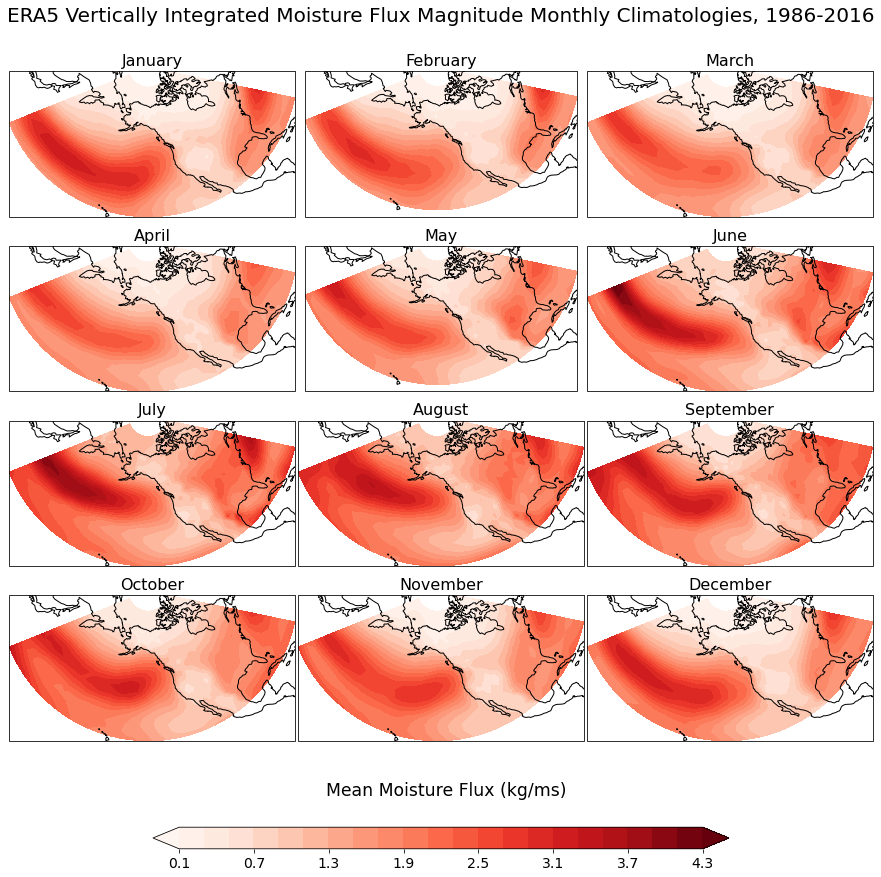

In [44]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the axes using the specified map projection
fig,axs=plt.subplots(4,3,subplot_kw={'projection':proj},figsize=(20,15))

for i,ax in enumerate(axs.flatten()):
    cs=ax.contourf(ds_clim['lon'],ds_clim['lat'],
                    ds_clim[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap='Reds',extend='both')
    ax.set_title(titles[i],fontdict={'fontsize':16})
    ax.coastlines()

plt.suptitle('ERA5 Vertically Integrated Moisture Flux Magnitude Monthly Climatologies, 1986-2016',fontsize=20)
plt.figtext(.42,.25,'Mean Moisture Flux (kg/ms)',fontsize='xx-large')

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.92, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
plt.savefig('vqvi.climo.1986-2016.png')